In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings("ignore")
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Dropout, MaxPool1D, Flatten
from sklearn.model_selection import train_test_split

In [17]:
# Setting the parameter to plot at 30x15 size
plt.rcParams['figure.figsize'] = 21, 13

In [3]:
root_folder_train = r'C:\Users\hp\Desktop\fdata\train'
root_folder_test = r'C:\Users\hp\Desktop\fdata\test'
category = ['Normal', 'Abnormal']
destination = r'C:\Users\hp\Desktop\New folder1'

In [4]:
# Function to load the dataset and do the required formatting to be able to feed the data into the Keras Model
def load_data(root_folder):
    # These are delcarations of variables that have been used inside the for loop
    final_list = list()
    labels = list()
    # It is iterating through both the categories Normal and Abnormal
    for cat in category:
        # It is taking and processing each file in the folder
        #for filename in os.listdir(root_folder+cat):
        for filename in os.listdir(os.path.join(root_folder, cat)):
            
            # Read each file for each category and drop the unnecessary columns
            path = os.path.join(root_folder, cat, filename)
            #path = root_folder + cat + '\\' + filename
            df = pd.read_csv(path) # Read the CSV using inbuilt Pandas Function
            df.drop(index=0, axis=0, inplace=True) # Drop the first row, which contains the units of measurement (useless for our use case)
            df=df.iloc[:7680]
            df.columns = ["time", "ECG0", "ECG1"] # Rename the columns for convinience and easy access of the columns
            df.drop(['time'], axis=1, inplace=True) # Drop the time column, as we are not using it as a time series. We are using the indexes instead
            df.ECG0 = pd.to_numeric(df.ECG0) # The data by default is in the form of an object, Convert each row into numeric or floating point
            df.ECG1 = pd.to_numeric(df.ECG1)
            
            print(filename, len(df))
            
            # Split each file into 6 parts and then make each of them a new row by transposing
            df_split = np.array_split(df, 30) # Split the dataset into 30 different sets. This is not mandatory, but is suggested since the dataset size is less
            for splitted_array in df_split:
                final_list.append(np.array(splitted_array)) # After splitting, we are appending all the splitted arrays into 1 single large array of 3 dimentions
                # The following if-else block is used to create labels. We have taken '1' for AF ECG and '0' for Normal ECG
                # This is not the ideal way to create labels, but this is the most simplest way for this situation
                if cat == 'Normal':
                    labels.append(0)
                if cat == 'Abnormal':
                    labels.append(1)

    # Before returning, convert the lists to arrays and increase the dmentions for being able to feed into the Neural Network
    return np.array(final_list), np.expand_dims(np.array(labels), axis=1)

In [5]:
# Load the training and testing dataset separately by calling the function for each of their root folder locations
X_train, y_train = load_data(root_folder_train)
X_test, y_test = load_data(root_folder_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

samples (1).csv 7680
samples (10).csv 7680
samples (11).csv 7680
samples (12).csv 7680
samples (13).csv 7680
samples (2).csv 7680
samples (3).csv 7680
samples (4).csv 7680
samples (5).csv 7680
samples (6).csv 7680
samples (7).csv 7680
samples (8).csv 7680
samples (9).csv 7680
samples.csv 7680
samples (1).csv 7680
samples (10).csv 7680
samples (11).csv 7680
samples (12).csv 7680
samples (13).csv 7680
samples (2).csv 7680
samples (3).csv 7680
samples (4).csv 7680
samples (5).csv 7680
samples (6).csv 7680
samples (7).csv 7680
samples (8).csv 7680
samples (9).csv 7680
samples.csv 7680
samples (14).csv 7680
samples (15).csv 7680
samples (16).csv 7680
samples (17).csv 7680
samples (14).csv 7680
samples (15).csv 7680
samples (16).csv 7680
samples (17).csv 7680
(840, 256, 2) (840, 1)
(240, 256, 2) (240, 1)


In [6]:
# Just printing out the dimentions to verify the data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(840, 256, 2) (840, 1)
(240, 256, 2) (240, 1)


In [7]:
# Build the model

# The model architecture type is sequential hence that is used
model = Sequential()

# We are using 4 convolution layers for feature extraction
model.add(Conv1D(filters=512, kernel_size=32, padding='same', kernel_initializer='normal', activation='relu', input_shape=(256, 2)))
model.add(Conv1D(filters=512, kernel_size=32, padding='same', kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2)) # This is the dropout layer. It's main function is to inactivate 20% of neurons in order to prevent overfitting
model.add(Conv1D(filters=256, kernel_size=32, padding='same', kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Conv1D(filters=256, kernel_size=32, padding='same', kernel_initializer='normal', activation='relu'))
model.add(MaxPool1D(pool_size=128)) # We use MaxPooling with a filter size of 128. This also contributes to generalization
model.add(Dropout(0.2))

# The prevous step gices an output of multi dimentional data, which cannot be fead directly into the feed forward neural network. Hence, the model is flattened
model.add(Flatten())
# One hidden layer of 128 neurons have been used in order to have better classification results
model.add(Dense(units=128, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
# The final neuron HAS to be 1 in number and cannot be more than that. This is because this is a binary classification problem and only 1 neuron is enough to denote the class '1' or '0'
model.add(Dense(units=1, activation='sigmoid'))

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 256, 512)          33280     
                                                                 
 conv1d_1 (Conv1D)           (None, 256, 512)          8389120   
                                                                 
 dropout (Dropout)           (None, 256, 512)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 256, 256)          4194560   
                                                                 
 dropout_1 (Dropout)         (None, 256, 256)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 256, 256)          2097408   
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 256)            0

In [8]:
# Train the mode
# To my experience, the Stocastic Gradient Descent Optimizer works the best. Adam optimizer also works but not as good as SGD
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train,  batch_size=64, epochs=6, validation_data=(X_test, y_test))

Epoch 1/6
14/14 [==============================] - 293s 21s/step - loss: 9.3012 - accuracy: 0.6095 - val_loss: 0.3815 - val_accuracy: 0.9000
Epoch 2/6
14/14 [==============================] - 289s 21s/step - loss: 1.0545 - accuracy: 0.7548 - val_loss: 0.5222 - val_accuracy: 0.7917
Epoch 3/6
14/14 [==============================] - 281s 20s/step - loss: 0.6276 - accuracy: 0.8167 - val_loss: 0.3956 - val_accuracy: 0.9250
Epoch 4/6
14/14 [==============================] - 267s 19s/step - loss: 0.6246 - accuracy: 0.7964 - val_loss: 0.3819 - val_accuracy: 0.9417
Epoch 5/6
14/14 [==============================] - 260s 19s/step - loss: 0.5143 - accuracy: 0.8286 - val_loss: 0.3905 - val_accuracy: 0.9417
Epoch 6/6
14/14 [==============================] - 253s 18s/step - loss: 0.4078 - accuracy: 0.8536 - val_loss: 0.3857 - val_accuracy: 0.9542


Text(0.5, 1.0, 'Accuracy Curves')

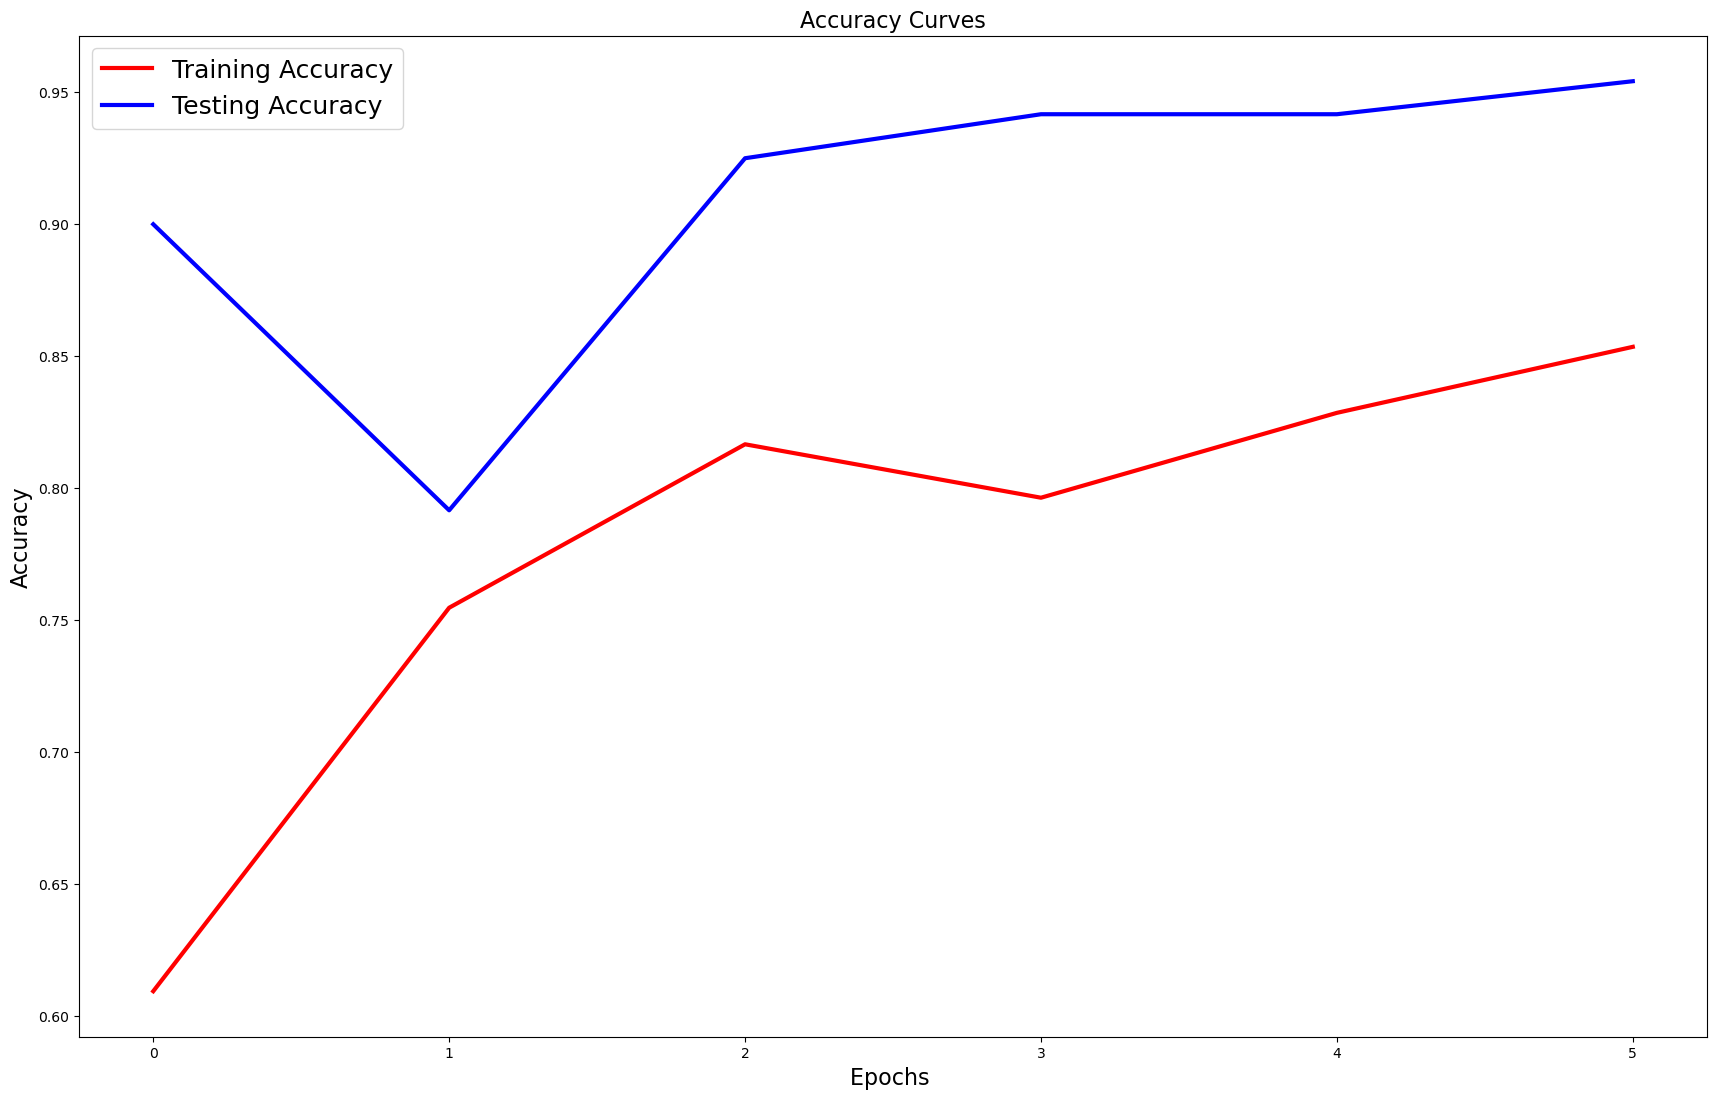

In [18]:
# Plot the model Accuracy graph (Ideally, it should be Logarithmic shape)
plt.plot(history.history['accuracy'],'r',linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0, label='Testing Accuracy')
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)

Text(0.5, 1.0, 'Loss Curves')

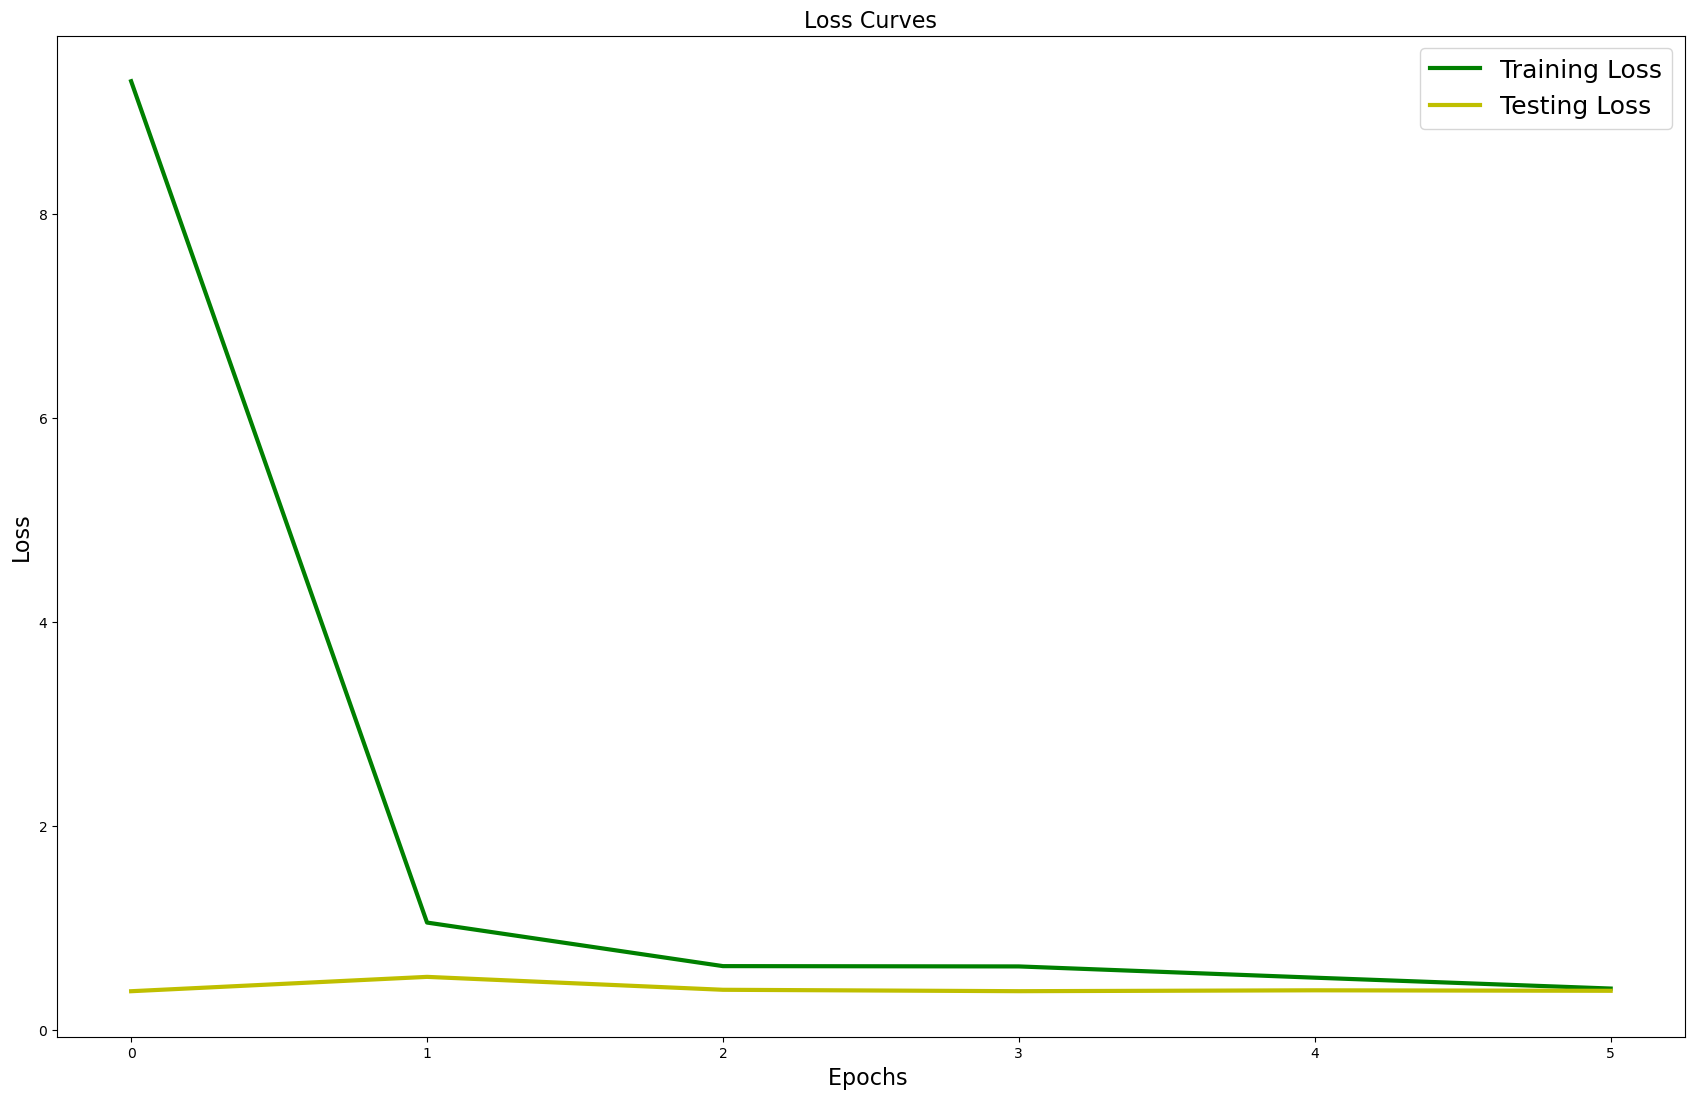

In [22]:
# Plot the model Loss graph (Ideally it should be Exponentially decreasing shape)
plt.plot(history.history['loss'], 'g', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'y', linewidth=3.0, label='Testing Loss')
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)